In [ ]:
from google.colab import files
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import re
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, multilabel_confusion_matrix

In [ ]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def build_vocab(datapath, embed_file):
    df = pd.read_csv(datapath)
    word2ix = dict()
    ix = 1 ## Zero for out of vocab words
    for inx, row in df.iterrows():
        #Get list of words in each sentence
        tokens = row['filtered_lemmatized_indic'][1:-1] ## Enter column for tokenized output
        tokens = tokens.replace('\'', '').split(', ')
        
        #Iterate through the words/tokens and add to dict
        for token in tokens:
            if token not in word2ix.keys():
                word2ix[token] = ix
                ix = ix+1
        
    #Use the pretrained embeddings to form coefficient dict
    embed_weights = dict()
    f = open(embed_file)
    embedding_dim = 0
    for line in f:
        values = line.split()
        token = values[0]
        weight = np.asarray(values[1:], dtype='float32')
        embedding_dim = len(weight)
        embed_weights[token] = weight
    f.close()
    
    ## Use the coefficients to form embedding matrix
    pretrained = np.zeros([len(word2ix)+1, embedding_dim])
    for token, i in word2ix.items():
        coeff = embed_weights.get(token)
        if coeff is not None:
            pretrained[i] = coeff
    
    return word2ix, pretrained

In [ ]:
class Dataset(Dataset):
    def __init__(self, datapath):
        self.df = pd.read_csv(datapath)
        
    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self,idx):
        taglist = ['fake', 'offensive', 'hate', 'defamation', 'non-hostile']
        
        sentence = self.df.iloc[idx]["filtered_lemmatized_indic"]
        sentence = sentence[1:-1].replace('\'', '').split(', ')
        
        MAX_LENGTH = 300 ## Pad shorter sequences and truncate rest
        sequence = list()
        for token in sentence:
            if token not in word2ix.keys():
                sequence.append(0)
            else:
                sequence.append(word2ix[token])
        
        if len(sequence) < MAX_LENGTH:
            sequence = list(np.zeros(MAX_LENGTH-len(sequence))) + sequence
        else:
            sequence = sequence[:MAX_LENGTH]
        
        ## Prepare labels
        labels = np.zeros(5)
        tags = self.df.iloc[idx]["labels"].split(",")
        for tag in tags:
            labels[taglist.index(tag)] = 1
        
        return np.array(sequence, dtype='long'), labels

In [ ]:
class rnn(nn.Module):
    
    def __init__(self, vocab, embed, hidden, out, nlayers, bi, dropout):
        super(rnn, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(pretrained) #Embedding
        #LSTM layer
        self.lstm = nn.LSTM(embed, hidden, num_layers=nlayers, bidirectional=bi, dropout=dropout, batch_first=True)
        #self.lstm = nn.GRU(embed, hidden, num_layers=nlayers, bidirectional=bi, dropout=dropout, batch_first=True)
        # Alternate GRU layer

        #Dense layer
        self.dense = nn.Linear(hidden*2, out)
        #Activation layer
        self.activation = nn.Sigmoid()
    
    def forward(self, text):
        embed = self.embedding(text)
        lstm_out,_ = self.lstm(embed)
        dense_out = self.dense(torch.mean(lstm_out, dim=1).squeeze())
        output = self.activation(dense_out)

        return output

In [ ]:
def train_model(model, iterator, optimizer, criterion):
    loss = 0
    model.train()
    predictions = np.zeros((1,5))
    true_labels = np.zeros((1,5))
    for batch in iterator:
        optimizer.zero_grad()   
        text, label = batch[0].to(device), batch[1].to(device)
        preds = model(text)
        batch_loss = criterion(preds.float(), label.float())
        batch_loss.backward()
        optimizer.step()
        loss += batch_loss.item()

        yhat = preds.to('cpu').detach().numpy() > 0.5
        ytrue = label.to('cpu')
        predictions = np.concatenate((predictions, yhat), 0)
        true_labels = np.concatenate((true_labels, ytrue), 0)

    f1 = f1_score(true_labels[1:], predictions[1:], average='weighted')
    return loss/len(iterator), f1

In [ ]:
def validate_model(model, iterator, criterion):
    loss = 0
    model.eval()
    predictions = np.zeros((1,5))
    true_labels = np.zeros((1,5))

    for batch in iterator:
        text, label= batch[0].to(device), batch[1].to(device)
        preds = model(text)
        batch_loss = criterion(preds.float(),label.float())
        loss += batch_loss.item()

        yhat = preds.to('cpu').detach().numpy() > 0.5
        ytrue = label.to('cpu')
        predictions = np.concatenate((predictions, yhat), 0)
        true_labels = np.concatenate((true_labels, ytrue), 0)

    f1 = f1_score(true_labels[1:], predictions[1:], average='weighted')
    return loss/len(iterator), f1

In [ ]:
word2ix, pretrained = build_vocab('/content/gdrive/My Drive/RNN/processed_df_train.csv', '/content/gdrive/My Drive/RNN/hi.txt') ## Enter the files for dataset and embeddings

In [ ]:
train = Dataset('/content/gdrive/My Drive/RNN/processed_df_train.csv') 
valid = Dataset('/content/gdrive/My Drive/RNN/processed_df_valid.csv')

In [ ]:
vocab = len(word2ix)+1
embed = 300 ## Replace with embedding_dim if using some other pre-trained embeddings
out = 5

## Hyperparamters
hidden = 128
nlayers = 2
bi = True
dropout = 0.2

#instantiate the model
pretrained = torch.Tensor(pretrained)
model = rnn(vocab, embed, hidden,out, nlayers, bi= True, dropout = dropout)
model.to(device)
print(model)

rnn(
  (embedding): Embedding(16043, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dense): Linear(in_features=256, out_features=5, bias=True)
  (activation): Sigmoid()
)


In [ ]:
#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

In [ ]:
min_loss = float('inf')
best_epoch = 0
epochs = 100
train_iter = DataLoader(train, batch_size=64, shuffle = True)
valid_iter = DataLoader(valid, batch_size=64, shuffle = True)

train_losses = []
valid_losses = []
f1_training = []
f1_validation = []

path = 'lstm_n2_h128.pt'

for epoch in range(epochs):
  
    train_loss, f1_train = train_model(model, train_iter, optimizer, criterion)
    valid_loss, f1_valid = validate_model(model, valid_iter, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    f1_training.append(f1_train)
    f1_validation.append(f1_valid)
    if valid_loss < min_loss:
      torch.save(model.state_dict(), path)
      best_epoch = epoch
      min_loss = valid_loss
    if epoch%10 == 0:
      print (f'Epoch:{epoch}/{epochs}=> Train Loss: {train_loss:.3f} Validation Loss:{valid_loss:.3f} F1 Train:{f1_train:.3f} F1 Valid:{f1_valid:.3f}')

Epoch:0/100=> Train Loss: 0.480 Validation Loss:0.454 F1 Train:0.312 F1 Valid:0.343
Epoch:10/100=> Train Loss: 0.340 Validation Loss:0.351 F1 Train:0.414 F1 Valid:0.404
Epoch:20/100=> Train Loss: 0.231 Validation Loss:0.357 F1 Train:0.671 F1 Valid:0.597
Epoch:30/100=> Train Loss: 0.166 Validation Loss:0.427 F1 Train:0.786 F1 Valid:0.617
Epoch:40/100=> Train Loss: 0.123 Validation Loss:0.457 F1 Train:0.886 F1 Valid:0.624
Epoch:50/100=> Train Loss: 0.088 Validation Loss:0.538 F1 Train:0.922 F1 Valid:0.629
Epoch:60/100=> Train Loss: 0.059 Validation Loss:0.671 F1 Train:0.953 F1 Valid:0.630
Epoch:70/100=> Train Loss: 0.040 Validation Loss:0.745 F1 Train:0.968 F1 Valid:0.631
Epoch:80/100=> Train Loss: 0.030 Validation Loss:0.749 F1 Train:0.978 F1 Valid:0.628
Epoch:90/100=> Train Loss: 0.038 Validation Loss:0.751 F1 Train:0.972 F1 Valid:0.617


In [ ]:
def predict(model, path, iterator, threshold=0.5):
    model.load_state_dict(torch.load(path))
    loss = 0
    model.eval()
    predictions = np.zeros((1,5))
    true_labels = np.zeros((1,5))
    prob = np.zeros((1,5))

    for batch in iterator:
        text, label= batch[0].to(device), batch[1].to(device)
        preds = model(text)
        batch_loss = criterion(preds.float(),label.float())
        loss += batch_loss.item()

        yhat = preds.to('cpu').detach().numpy() #> threshold
        ytrue = label.to('cpu')
        prob = np.concatenate((prob, yhat), 0)
        predictions = np.concatenate((predictions, yhat>threshold), 0)
        true_labels = np.concatenate((true_labels, ytrue), 0)

    f1 = f1_score(true_labels[1:], predictions[1:], average='weighted')
    recall = recall_score(true_labels[1:], predictions[1:], average='weighted')
    precision = precision_score(true_labels[1:], predictions[1:], average='weighted')
    accuracy = accuracy_score(true_labels[1:], predictions[1:])
  
    print (f'F1:{f1:.4f} Recall:{recall:.4f} Precision:{precision:.4f} Accuracy:{accuracy:.4f}')
    cm = multilabel_confusion_matrix(true_labels[1:], predictions[1:])
    taglist = ['fake', 'offensive', 'hate', 'defamation', 'non-hostile']
    for i in range(5):
      print(taglist[i])
      print(cm[i])
      print()
    return true_labels[1:], prob[1:]

In [ ]:
train_true, train_pred = predict(model, path, train_iter)

F1:0.6838 Recall:0.6454 Precision:0.7809 Accuracy:0.6526
fake
[[4341  243]
 [ 292  852]]

offensive
[[4962   24]
 [ 625  117]]

hate
[[4690  246]
 [ 482  310]]

defamation
[[5164    0]
 [ 564    0]]

non-hostile
[[2599   79]
 [ 268 2782]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
val_true, val_pred = predict(model, path, valid_iter)

F1:0.5904 Recall:0.5537 Precision:0.6874 Accuracy:0.5660
fake
[[576  75]
 [ 63  97]]

offensive
[[704   4]
 [ 89  14]]

hate
[[663  38]
 [ 81  29]]

defamation
[[734   0]
 [ 77   0]]

non-hostile
[[336  40]
 [ 85 350]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
best_epoch

7

In [ ]:
def prc(true_labels, prob):
  taglist = ['fake', 'offensive', 'hate', 'defamation', 'non-hostile']
  threshold = [x/10 for x in range(1, 10)]
  #print(threshold)
  for i in range(5):
    prec = []
    rec = []
    f1_sc = []
    acc = []
    for t in threshold:
      predictions = prob[:,i] > t
      f1 = f1_score(true_labels[:,i], predictions, average='weighted')
      recall = recall_score(true_labels[:,i], predictions, average='weighted')
      precision = precision_score(true_labels[:,i], predictions, average='weighted')
      accuracy = accuracy_score(true_labels[:,i], predictions)

      prec.append(precision)
      rec.append(recall)
      f1_sc.append(f1)
      acc.append(accuracy)
    
    #print(len(rec))
    fig, ax = plt.subplots(figsize=(10,5))
    fig.suptitle(taglist[i])
    inx = np.argsort(rec)
    #print(len(inx))
    #print(inx, prec)
    prec = np.array(prec)[inx]
    rec = np.sort(rec)
    thresh = np.array(threshold)[inx]
    ax.plot(rec, prec, '-bo')
    for j in range(9):
      ax.annotate(thresh[j], (rec[j], prec[j]))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    #plt.savefig(taglist[i]+'_prc_gru.jpg')

    plt.figure(figsize=(10,5))
    plt.plot(threshold, f1_sc, '-bo')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    #plt.savefig(taglist[i]+'_f1_gru.jpg')
    #plt.title(taglist[i])

In [ ]:
path = 'gru_n2_h128.pt'

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


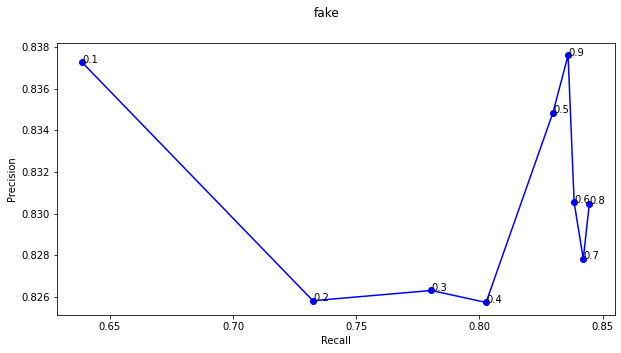

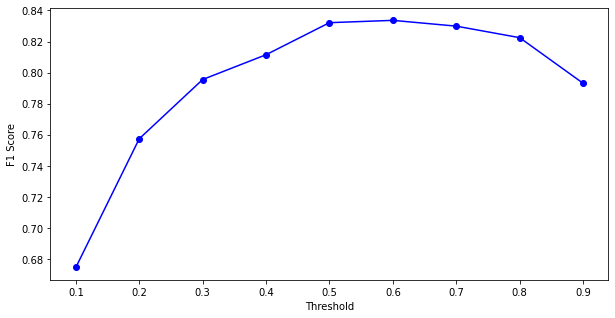

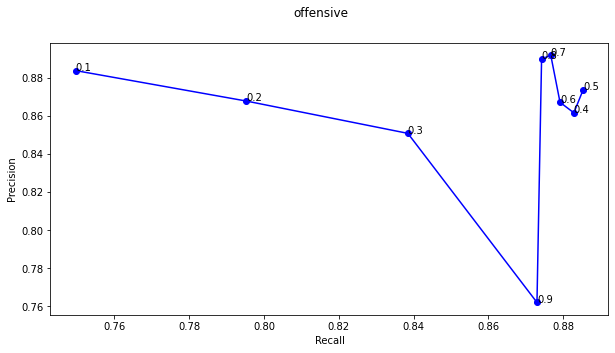

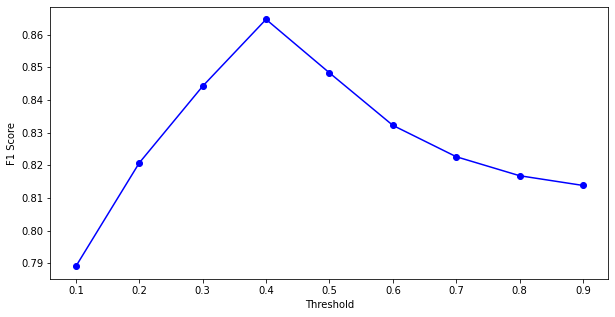

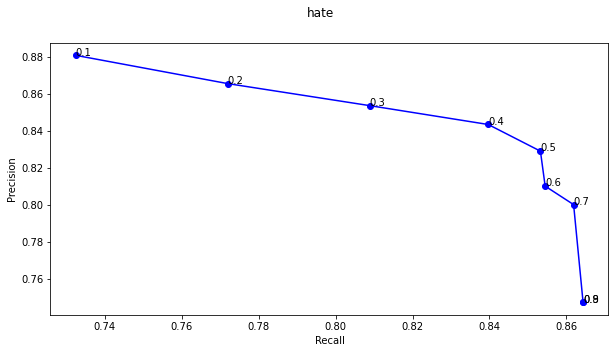

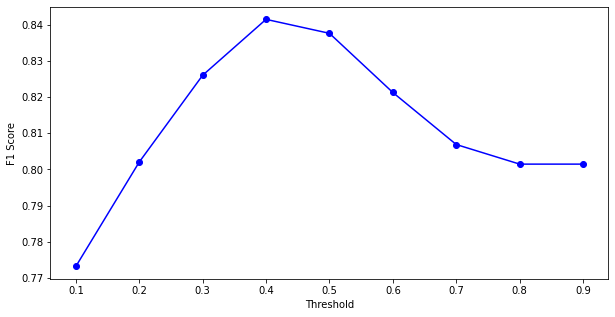

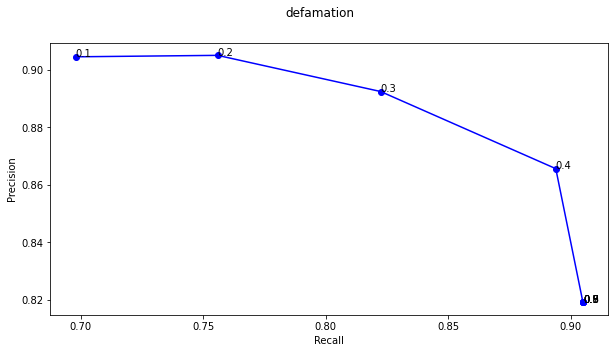

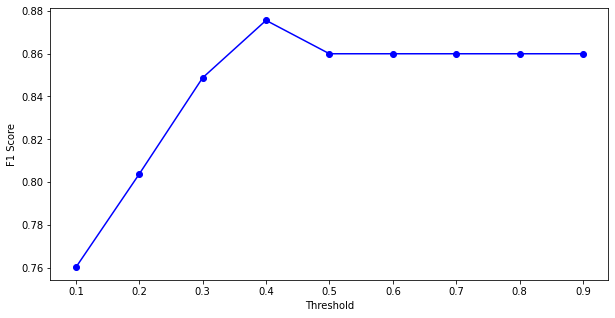

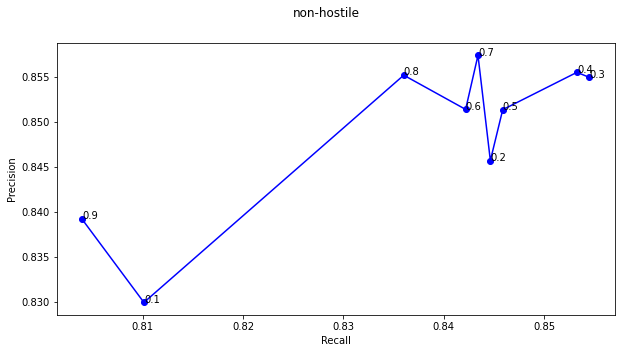

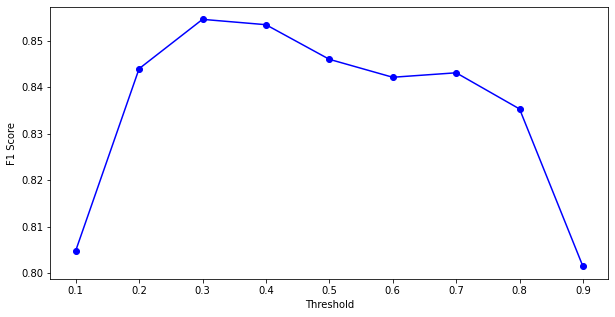

In [ ]:
prc(val_true, val_pred)

In [ ]:
val = val_pred.copy()

In [ ]:
def test(val_true, val):
  #thresh = [0.4,0.5,0.3,0.3,0.6] -- LSTM
  thresh = [0.6,0.5,0.4,0.4,0.3] # -- GRU
  for i in range(5):
    val[:,i] = val[:,i] > thresh[i]

  f1 = f1_score(val_true, val, average='weighted')
  recall = recall_score(val_true, val, average='weighted')
  precision = precision_score(val_true, val, average='weighted')
  accuracy = accuracy_score(val_true, val)
  print("F1:{} Rec:{} Prec:{} Acc:{}".format(f1, recall, precision, accuracy))
  cm = multilabel_confusion_matrix(val_true, val)
  taglist = ['fake', 'offensive', 'hate', 'defamation', 'non-hostile']
  for i in range(5):
    print(taglist[i])
    print(cm[i])
    print()

In [ ]:
test(val_true, val)

F1:0.6231155818509009 Rec:0.5875706214689266 Prec:0.7199079563985374 Acc:0.5709001233045623
fake
[[597  54]
 [ 77  83]]

offensive
[[704   4]
 [ 89  14]]

hate
[[633  68]
 [ 62  48]]

defamation
[[712  22]
 [ 64  13]]

non-hostile
[[330  46]
 [ 73 362]]



In [ ]:
test(train_true, train_pred.copy())

F1:0.7195249768898567 Rec:0.6934202161474888 Prec:0.8123652733177796 Acc:0.6730097765363129
fake
[[4423  161]
 [ 353  791]]

offensive
[[4962   24]
 [ 625  117]]

hate
[[4477  459]
 [ 313  479]]

defamation
[[5032  132]
 [ 462  102]]

non-hostile
[[2524  154]
 [ 176 2874]]



In [ ]:
import matplotlib.pyplot as plt

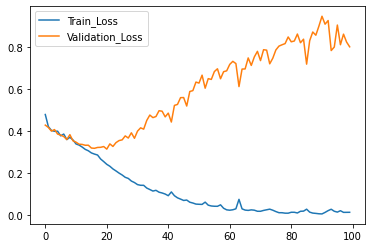

In [ ]:
## lr = 1e-04
plt.plot(train_losses, label='Train_Loss')
plt.plot(valid_losses, label='Validation_Loss')
plt.legend()

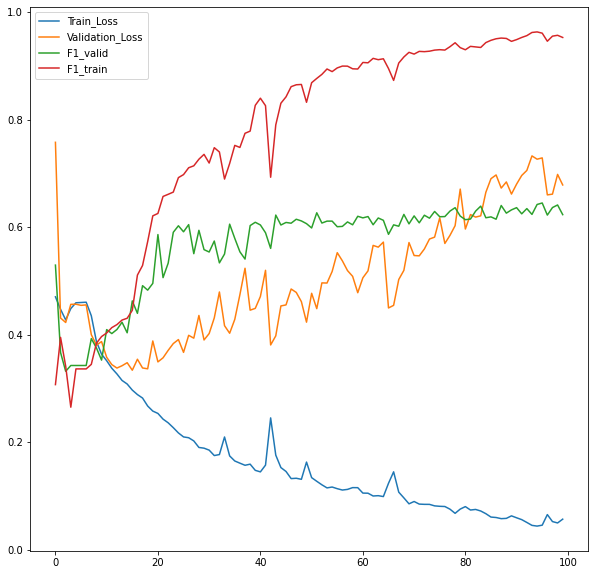

In [ ]:
## lr = Default
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Train_Loss')
plt.plot(valid_losses, label='Validation_Loss')
plt.plot(f1_validation, label='F1_valid')
plt.plot(f1_training, label='F1_train')
plt.legend()

In [ ]:
print(max(f1_validation))

0.40904310708057356


In [ ]:
f1_validation

[0.4100427583038686,
 0.4409687528409921,
 0.41970937615033393,
 0.44065736176426595,
 0.47038814739351187,
 0.4200676524871686,
 0.4431200451637979,
 0.4599835690641481,
 0.46491727920662496,
 0.48003548418292824]